## Tutorial 2: Quantum Kernel
#### Julien Rauch, December 2025

Documentation from KIT: https://publikationen.bibliothek.kit.edu/1000148603

### 1 - Introduction
In quantum machine learning, the first step is often to figure out how to include our data in the quantum circuit. To do this, we use variational circuits (also known as quantum maps). The transformation of classical data into quantum states is called quantum embbeding.

- For a feature map (quantum circuit for data embedding) $\phi$ : $𝑋 \rightarrow 𝐻^n$ , and an inner product defined on $𝐻^n$.
- We defines a kernel function as: $k(x_i, x_j) = |\braket{\phi(x_i)|\phi(x_j)}_{H^n}|^2$. We can see it like a measure of similarity between $x_i$ and $x_j$ in the Hilbert space.

Finally, the kernel method makes it possible to calculate distances or similarities in a projection space (often in higher dimensions) without having to recalculate their new position. It's call Kernel trick.

### 2 - Quantum Embedding

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

To get started, we propose to use an extremely simple circuit for embedding: a simple phase encoding with one feature per qubit but "vertical repetition". 
Here is an example of this circuit for 3 qubits and data vector of 2 features:

![image](./img/circuit_embedding.png)

Implement the function that returns the circuit of ```nb_qubits``` for a data vector embedding of ```nb_feature``` :

In [4]:
def embbeding_circuit(nb_qubit, nb_feature, name="input"):
    """
        nb_qubit : number of qubits in the circuit
        nb_feature : number of features of a data vector
        name : name will be the identifier of the ParameterVector
        This function return the circuit of embedding
    """
    x = ParameterVector(name, nb_feature)
    qc = QuantumCircuit(nb_qubit)
    
    # TODO
    for i in range(nb_qubit):
        qc.h(i)
        qc.rz(x[i%nb_feature], i)
    return qc
    

In [5]:
# Print the circuit
embbeding_circuit(3,2).draw() # Basic printing, you can improve

┌───┐┌──────────────┐
q_0: ┤ H ├┤ Rz(input[0]) ├
     ├───┤├──────────────┤
q_1: ┤ H ├┤ Rz(input[1]) ├
     ├───┤├──────────────┤
q_2: ┤ H ├┤ Rz(input[0]) ├
     └───┘└──────────────┘

Now that we have a circuit that transforms our classical data into a quantum state, we can calculate the ```fidelity```, which is a measure of similarity in the space of quantum states.

### 3 - Fidelity Circuit

We have two methods for calculating the fidelity between two quantum states: the adjoint method and the swap test.

#### 3.1 - Calculation using the Adjoint Method 

Consider the following circuit:

![image](./img/adjoint.png)

Previousely for kernel function $k$ we defined: $k(x_i, x_j) = |\braket{\phi(x_i)|\phi(x_j)}_{H^n}|^2$

So, for the feature map $U$, we have $k(x_i, x_j) = |\braket{\phi(x_i)|\phi(x_j)}_{H^n}|^2 = |\bra{0}U(x_i) U^\dag(x_j)\ket{0}_H|^2$. 

This corresponds to the probability of having $\ket{0}$ at the output of the circuit $U(x_i) U^\dag(x_j)$.

Implement the adjoint methode circuit :
- Use ```embbeding_circuit``` to create an embedding circuit qc1 with the parameters name "input1"
- Use ```embbeding_circuit``` to create an embedding circuit qc2 with the parameters name "input2"
- Inverse the circuit qc2 and add it to the circuit qc1 (do it yourself or ask Qiskit)
- Add measurement on all qubits of the final circuit
- Return the final circuit

In [6]:
def fidelity_adjoint_circuit(nb_qubit, nb_feature):
    """
        nb_qubit : nomber of qubits in the circuit
        nb_feature : nb_feature of data
        This function insert the data in the circuit for fidelity with adjoint method
    """
    # TODO
    qc1 = embbeding_circuit(nb_qubit, nb_feature, "input1")
    qc2 = embbeding_circuit(nb_qubit, nb_feature, "input2")
    #qc2.inverse()
    qc1.compose(qc2.inverse(), inplace=True)
    qc1.measure_all()
    return qc1
    

In [7]:
# Print the final circuit
#fidelity_adjoint_circuit(3, 2).draw()







# TODO
fidelity_adjoint_circuit(3, 2).decompose().draw()

global phase: (-0.5)*input1[0] - 0.5*input1[1] - 0.5*input1[0] + 0.5*input2[0] + 0.5*input2[1] + 0.5*input2[0]
        ┌────────────┐┌──────────────┐┌───────────────┐┌────────────┐ ░ ┌─┐   »
   q_0: ┤ U(π/2,0,π) ├┤ P(input1[0]) ├┤ P(-input2[0]) ├┤ U(π/2,0,π) ├─░─┤M├───»
        ├────────────┤├──────────────┤├───────────────┤├────────────┤ ░ └╥┘┌─┐»
   q_1: ┤ U(π/2,0,π) ├┤ P(input1[1]) ├┤ P(-input2[1]) ├┤ U(π/2,0,π) ├─░──╫─┤M├»
        ├────────────┤├──────────────┤├───────────────┤├────────────┤ ░  ║ └╥┘»
   q_2: ┤ U(π/2,0,π) ├┤ P(input1[0]) ├┤ P(-input2[0]) ├┤ U(π/2,0,π) ├─░──╫──╫─»
        └────────────┘└──────────────┘└───────────────┘└────────────┘ ░  ║  ║ »
meas: 3/═════════════════════════════════════════════════════════════════╩══╩═»
                                                                         0  1 »
«           
«   q_0: ───
«           
«   q_1: ───
«        ┌─┐
«   q_2: ┤M├
«        └╥┘
«meas: 3/═╩═
«         2

#### 3.2 - Calculation using swap tests

For a swap test, we use 3 quantum registers: 
- The first, composed of a single qubit, will be used to recover fidelity. 
- The second contains the quantum state corresponding to the first data vector $x_i$.
- The last register contains the quantum state corresponding to the second data vector $x_j$.

Quantum state composed of the 3 registers: $\ket{0} \otimes \ket{\phi(x_i)} \otimes \ket{\phi(x_j)}$

Then we apply:
- An H gate to the qubit of the first register
- A swap gate controlled by the first register qubit and apply to the two quantum registers encoding our data vecors. 
- A second H gate to the qubit in the first register.
- And finally we measure the qubit in the first register.

![image](./img/swaptest.png)

Course recap:
The probability to measure 0 on the first qubit is: $p(0) = \frac{1}{2} + \frac{1}{2}|\braket{\phi(x_i)|\phi(x_j)}|^2$. And the probability to measure 1 on the first qubit is: $p(0) = \frac{1}{2} - \frac{1}{2}|\braket{\phi(x_i)|\phi(x_j)}|^2$

Implement the swap test circuit :
- Use ```embbeding_circuit``` to create an embedding circuit qc1 with the parameters name "input1"
- Use ```embbeding_circuit``` to create an embedding circuit qc2 with the parameters name "input2"
- Add qc1 after the qubit 0 with ```compose```
- Add qc2 after the qubit nb_qubit with ```compose```
- Implement the SwapTest controlled by qubit 0
- Measure qubit 0 of the final circuit
- Return the final circuit

In [8]:
def fidelity_SwapTest_circuit(nb_qubit, nb_feature):
    """
        nb_qubit : number of qubits in each embedding circuit
        nb_feature : number of features of each data vectors
        This function insert the data vectors in the circuit for fidelity computation with Swap Test
    """
    qc = QuantumCircuit(2*nb_qubit + 1, 1)
    qc1 = embbeding_circuit(nb_qubit, nb_feature, "input1")
    qc2 = embbeding_circuit(nb_qubit, nb_feature, "input2")
    qc.compose(qc1, qubits=list(range(1,nb_qubit+1)), inplace=True)
    qc.compose(qc2, qubits=list(range(nb_qubit+1,2*nb_qubit+1)), inplace=True)
    qc.h(0)
    for i in range(nb_qubit):
        qc.cswap(0,i+1,i+nb_qubit+1)
    qc.h(0)
    qc.measure(0,0)
    return qc
    # TODO
    

In [9]:
# Print the final circuit
fidelity_SwapTest_circuit(3, 2).draw()

┌───┐                          ┌───┐┌─┐
q_0: ┤ H ├──────────────────■──■──■─┤ H ├┤M├
     ├───┤┌───────────────┐ │  │  │ └───┘└╥┘
q_1: ┤ H ├┤ Rz(input1[0]) ├─X──┼──┼───────╫─
     ├───┤├───────────────┤ │  │  │       ║ 
q_2: ┤ H ├┤ Rz(input1[1]) ├─┼──X──┼───────╫─
     ├───┤├───────────────┤ │  │  │       ║ 
q_3: ┤ H ├┤ Rz(input1[0]) ├─┼──┼──X───────╫─
     ├───┤├───────────────┤ │  │  │       ║ 
q_4: ┤ H ├┤ Rz(input2[0]) ├─X──┼──┼───────╫─
     ├───┤├───────────────┤    │  │       ║ 
q_5: ┤ H ├┤ Rz(input2[1]) ├────X──┼───────╫─
     ├───┤├───────────────┤       │       ║ 
q_6: ┤ H ├┤ Rz(input2[0]) ├───────X───────╫─
     └───┘└───────────────┘               ║ 
c: 1/═════════════════════════════════════╩═
                                          0

### 4 - Fidelity computation

In [10]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

nb_shots = 1024 #1024 by default
sim = AerSimulator(shots=nb_shots)

We want to compute the fidelity between data vectors $v1$ and $v2$ :

In [11]:
v1, v2 = [0.2,0.2], [0.8,0.8]

#### 4.1 - Using adjoint method

- Create the circuit with ```fidelity_adjoint_circuit``` with 3 qubits
- Transpile the circuit
- Assign the vector v1 to the ParameterVector named "input1" : look the documentation of ```qc.assign_parameters``` (```qc.assign_parameters({"input1["+str(i)+"]":v1[i] for i in range(2)})```)
- Assign the vector v2 to the ParameterVector named "input2"
- Run the simulation and compute the fidelity / similarity between v1 and v2

In [12]:
# Print the final circuit
fidelity_SwapTest_circuit(3, 2).draw()

┌───┐                          ┌───┐┌─┐
q_0: ┤ H ├──────────────────■──■──■─┤ H ├┤M├
     ├───┤┌───────────────┐ │  │  │ └───┘└╥┘
q_1: ┤ H ├┤ Rz(input1[0]) ├─X──┼──┼───────╫─
     ├───┤├───────────────┤ │  │  │       ║ 
q_2: ┤ H ├┤ Rz(input1[1]) ├─┼──X──┼───────╫─
     ├───┤├───────────────┤ │  │  │       ║ 
q_3: ┤ H ├┤ Rz(input1[0]) ├─┼──┼──X───────╫─
     ├───┤├───────────────┤ │  │  │       ║ 
q_4: ┤ H ├┤ Rz(input2[0]) ├─X──┼──┼───────╫─
     ├───┤├───────────────┤    │  │       ║ 
q_5: ┤ H ├┤ Rz(input2[1]) ├────X──┼───────╫─
     ├───┤├───────────────┤       │       ║ 
q_6: ┤ H ├┤ Rz(input2[0]) ├───────X───────╫─
     └───┘└───────────────┘               ║ 
c: 1/═════════════════════════════════════╩═
                                          0

In [13]:
# TODO
qc = fidelity_adjoint_circuit(3, 2)
#transpile the circuit
qc = transpile(qc, sim)
#assign the parameters
qc=qc.assign_parameters({"input1[0]":0.2, "input1[1]":0.2, "input2[0]":0.8, "input2[1]":0.8})
#run the simulation
result = sim.run(qc).result()
#get the counts
counts = result.get_counts()
#print the counts
print(counts)


#compute the fidelity
#get the proba of havingn something that starts with 0
nb_0 = 0
for key in counts:
    if key[0] == "0":
        nb_0 += counts[key]

fidelity = counts.get("000", 0) / nb_shots
print(f"Fidelity: {fidelity}")

{'111': 1, '011': 11, '101': 4, '110': 6, '001': 62, '100': 80, '010': 73, '000': 787}
Fidelity: 0.7685546875


#### 4.2 - Using swap test

- Create the circuit with ```fidelity_SwapTest_circuit``` with 3 qubits
- Transpile the circuit
- Assign the vector v1 to the ParameterVector named "input1" : look the documentation of ```qc.assign_parameters``` (```qc.assign_parameters({"input1["+str(i)+"]":v1[i] for i in range(2)})```)
- Assign the vector v2 to the ParameterVector named "input2"
- Run the simulation and compute the fidelity / similarity between v1 and v2

In [14]:
# TODO
qc = fidelity_SwapTest_circuit(3, 2)
#transpile the circuit
qc = transpile(qc, sim)
#assign the parameters
qc=qc.assign_parameters({"input1[0]":0.2, "input1[1]":0.2, "input2[0]":0.8, "input2[1]":0.8})
#run the simulation
result = sim.run(qc).result()
#get the counts
counts = result.get_counts()
#print the counts
print(counts)

#compute the fidelity
#get the proba of havingn something that starts with 0
nb_0 = 0
for key in counts:
    if key[0] == "0":
        nb_0 += counts[key]
p0 = nb_0 / nb_shots
fidelity = 2 * p0 - 1
print(f"Fidelity: {fidelity}")


{'1': 133, '0': 891}
Fidelity: 0.740234375


#### 4.3 - Similarities check

Are the fidelities close ?


Try to increase the number of shots. What do you observe ?

With 100 000 samples

For adjoint method, fidelity is 0.759, and for swap test, it's 0.760, they are close on our test,  the exact flaot change all the times, but they always are around 0.75

### 5 - Similarity Matrix Computation

We've still only got one circuit to run so far. As we have many circuits to execute, we will use the Sampler to send or simulate several circuits in one job.

In [15]:
%pip install qiskit-ibm-runtime

Note: you may need to restart the kernel to use updated packages.


In [16]:
import numpy as np
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

# The pass manager performs transpilation, optimized for a target machine if specified
pm = generate_preset_pass_manager(backend=sim, optimization_level=1) 

#### 5.1 - Using adjoint method

- Create the circuit with ```fidelity_adjoint_circuit``` and use the pass_manager to transpile it
- For a dataset of n vectors, construct the list of all circuits needed to compute all similarities (using ```assign_parameters```)
- Create a Sampler object and uses it to create a job and to run it
- Make the similarity matrix from the job result:
    + For the bitstring use: result.data.meas.get_bitstrings()
    + For the number of shots use: result.metadata["shots"]

In [17]:
def similarity_adjoint(nb_qubit, nb_feature, dataset, backend, pass_manager):
    n = len(dataset)
    res = np.zeros((n,n)) # similarity matrix to be completed
    qc_base = fidelity_adjoint_circuit(nb_qubit, nb_feature)
    qc_base = pass_manager.run(qc_base)
    
    # String of all zeros to check (e.g., "00" for 2 qubits)
    all_zeros = "0" * nb_qubit
    nb_shots = backend._options.get("shots")
    
    # Fill the diagonal with 1 (similarity with itself)
    for i in range(n):
        res[i][i] = 1.0
    
    # Compute similarities for all pairs
    for i in range(n):
        for j in range(i+1, n):
            dict_i = {}
            for k in range(nb_feature):
                dict_i[f"input1[{k}]"] = dataset[i][k]
                dict_i[f"input2[{k}]"] = dataset[j][k]
            
            qc = qc_base.assign_parameters(dict_i)
            job = backend.run(qc)
            result = job.result()
            counts = result.get_counts()
            
            # Fidelity = probability of measuring all qubits at 0
            fidelity = counts.get(all_zeros, 0) / nb_shots
            
            # Fill the matrix (symmetric)
            res[i][j] = fidelity
            res[j][i] = fidelity
    
    return res

In [ ]:
def similarity_adjoint_optimized(nb_qubit, nb_feature, dataset, backend, pass_manager):
    n = len(dataset)
    res = np.zeros((n, n))
    qc_base = fidelity_adjoint_circuit(nb_qubit, nb_feature)
    qc_base = pass_manager.run(qc_base) 
    all_zeros = "0" * nb_qubit
    nb_shots = backend._options.get("shots")

    list_of_circuits = []
    pairs_indices = [] 

    for i in range(n):
        res[i][i] = 1.0 
        for j in range(i + 1, n):
            dict_params = {}
            for k in range(nb_feature):
                dict_params[f"input1[{k}]"] = dataset[i][k]
                dict_params[f"input2[{k}]"] = dataset[j][k]
            
    
            qc = qc_base.assign_parameters(dict_params)
            list_of_circuits.append(qc)
            pairs_indices.append((i, j))

    print(f"Lancement de la simulation pour {len(list_of_circuits)} circuits...")
    job = backend.run(list_of_circuits) 
    result = job.result()
    all_counts = result.get_counts()

    for idx, (i, j) in enumerate(pairs_indices):
        counts = all_counts[idx]
        fidelity = counts.get(all_zeros, 0) / nb_shots
        res[i][j] = fidelity
        res[j][i] = fidelity
        
    return res

In [19]:
# Compute and print the similarity matrix
similarity_adjoint(2, 1, [[0.2], [0.8], [1.4]], sim, pm)

array([[1.        , 0.83300781, 0.48632812],
       [0.83300781, 1.        , 0.83886719],
       [0.48632812, 0.83886719, 1.        ]])

#### 5.2 - Using swap test

- Create the circuit with ```fidelity_SwapTest_circuit``` and uses the pass_manager to transpile it
- For a dataset of n vectors, construct the list of all circuits needed to compute all similarities (using ```assign_parameters```)
- Create a Sampler object and uses it to create a job and to run it
- Make the similarity matrix from the job result:
    + For the bitstring use: result.data.meas.get_bitstrings()
    + For the number of shots use: result.metadata["shots"]

In [20]:
def similarity_swap(nb_qubit, nb_feature, dataset, backend, pass_manager):
    n = len(dataset)
    res = np.zeros((n,n)) # similarity matrix to be completed
    qc_base = fidelity_SwapTest_circuit(nb_qubit, nb_feature)
    qc_base = pass_manager.run(qc_base)
    
    # String of all zeros to check (e.g., "00" for 2 qubits)
    all_zeros = "0" * nb_qubit
    nb_shots = backend._options.get("shots")
    
    # Fill the diagonal with 1 (similarity with itself)
    for i in range(n):
        res[i][i] = 1.0
    
    # Compute similarities for all pairs
    for i in range(n):
        for j in range(i+1, n):
            dict_i = {}
            for k in range(nb_feature):
                dict_i[f"input1[{k}]"] = dataset[i][k]
                dict_i[f"input2[{k}]"] = dataset[j][k]
            
            qc = qc_base.assign_parameters(dict_i)
            job = backend.run(qc)
            result = job.result()
            counts = result.get_counts()
            
            # Fidelity = probability of measuring all qubits at 0
            nb_0 = 0
            for key in counts:
                if key[0] == "0":
                    nb_0 += counts[key]
            p0 = nb_0 / nb_shots
            fidelity = 2 * p0 - 1
            res[i][j] = fidelity
            res[j][i] = fidelity
    return res

In [21]:
# Compute and print the similarity matrix
similarity_swap(2, 1, [[0.2], [0.8], [1.4]], sim, pm)

array([[1.        , 0.82617188, 0.48828125],
       [0.82617188, 1.        , 0.8359375 ],
       [0.48828125, 0.8359375 , 1.        ]])

### 6 - Data Clustering with Quantum Kernel Method

To cluster the data, we need to compare it, either by calculating their distance or their similarity (the inverse of distance) using results of previous exercises.

In [22]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


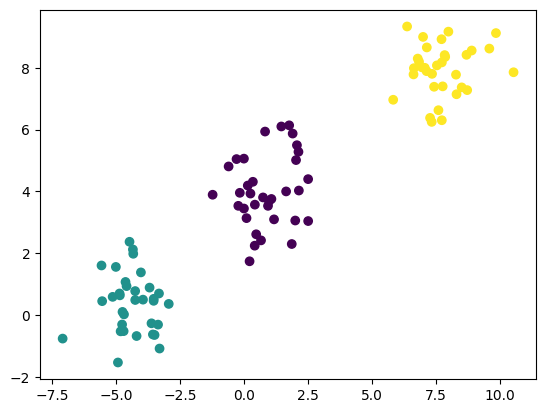

In [23]:
from sklearn.datasets import make_blobs
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Dataset configuration
NB_DATA = 100
NB_CLUSTER = 3

X, labels = make_blobs(n_samples=NB_DATA, centers=NB_CLUSTER, n_features=2, random_state=3)
plt.scatter(X[:,0], X[:,1], c=labels)

#### 6.1 - Data preprocessing 

Which preprocessing do you think is necessary ?

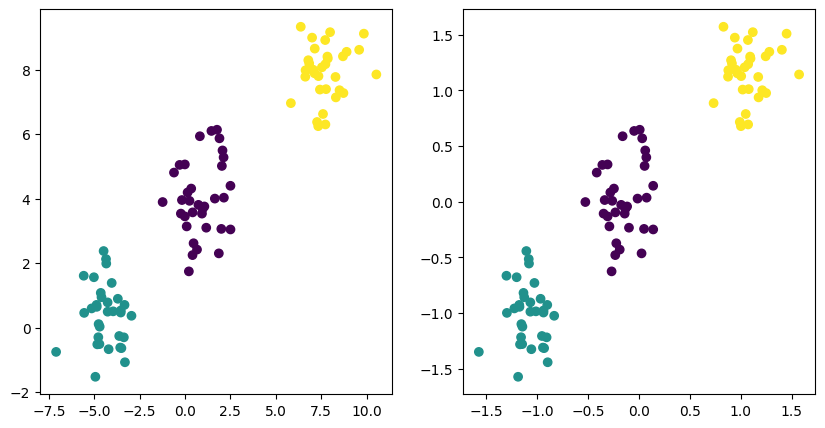

In [24]:
from sklearn.preprocessing import MinMaxScaler
# X = ...
# NORMALIZE THE DATA: norm(v) = 1, c'est le plus simple pour le moment, on pourraitaussi les scales entre -pi et pi, ...
# il y a probablement d'autres methodes a explorer, notamment les methodes du premier TP pour le iris dataset
NB_DATA = 100
NB_CLUSTER = 3

X, labels = make_blobs(n_samples=NB_DATA, centers=NB_CLUSTER, n_features=2, random_state=3)
scaler = MinMaxScaler(feature_range=(-np.pi/2, np.pi/2))


# X_NORMALIZED = preprocessing.normalize(X)
X_NORMALIZED = scaler.fit_transform(X)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(X[:,0], X[:,1], c=labels)
axs[1].scatter(X_NORMALIZED[:,0], X_NORMALIZED[:,1], c=labels)
plt.show()

#### 6.2 - Similarity matrix computation

In [25]:
# TODO: call one of your similarity matrix computation, computation time: 2mn54 for adjoint method
#similarity = ...
similarity_adjoint_matrix = similarity_adjoint_optimized(2, 2, X_NORMALIZED, sim, pm)
#similarity_swap = similarity_swap(2, 1, X_NORMALIZED, sim, pm)
# Nice print of the similarity matrix
#plt.imshow(
#    similarity, interpolation="nearest", origin="upper", cmap="Blues"
#)

Lancement de la simulation pour 4950 circuits...


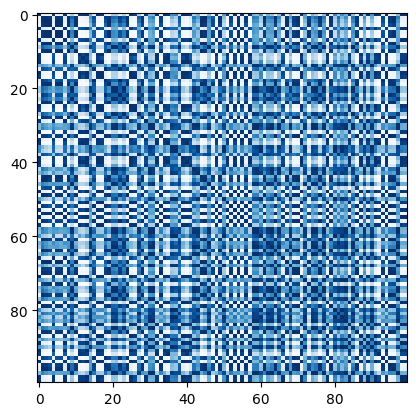

In [26]:
plt.imshow(similarity_adjoint_matrix, interpolation="nearest", origin="upper", cmap="Blues")

#### 6.3 - Data Clustering

In [27]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

Clustering score: 1.0


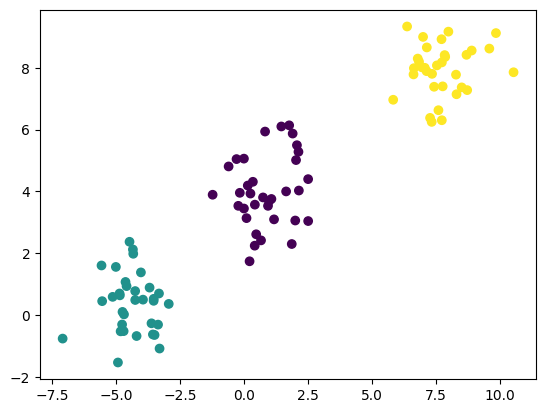

In [28]:
# Run a spectral clustering from similarity matrix
adhoc_spectral = SpectralClustering(3, affinity="precomputed")
cluster_labels = adhoc_spectral.fit_predict(similarity_adjoint_matrix)

# Compute the NMI metric that gives the quality of the results (comparaison to official labeling)
cluster_score = normalized_mutual_info_score(cluster_labels, labels)

# Print the NMI result
print(f"Clustering score: {cluster_score}")

# Display the dataset with computed labeling
plt.scatter(X[:,0], X[:,1], c=cluster_labels)

### 7 - Noisy Simulation

We experiment the noise impact of a real IBM machine (Brisbane): https://qiskit.github.io/qiskit-aer/tutorials/2_device_noise_simulation.html

- Create a new simulator (AerSimulator) with ```FakeBrisbane```
- Create the corresponding PassManager
- Perform exactly the same clustering, but with the noisy simulator
    - Warning: Noisy simulation can take a long time !

In [29]:
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
#TODO   
device_backend = FakeBrisbane()
sim_noisy = AerSimulator.from_backend(device_backend)

pm = generate_preset_pass_manager(backend=sim_noisy, optimization_level=1)
#I think reading the paper is necessary to implement clustering correctly, for the moment I'll just try to compute the similarity matrix
similarity_adjoint_noisy = similarity_adjoint_optimized(2, 2, X_NORMALIZED, sim_noisy, pm)
#or similarity_swap_noisy = similarity_swap(2, 1, X_NORMALIZED, sim_noisy, pm)
#plt.imshow(similarity_adjoint_noisy, interpolation="nearest", origin="upper", cmap="Blues")
#EN CAS DE NOISE, SWAP est plus robuste (cf p. 35 du papier)

Lancement de la simulation pour 4950 circuits...


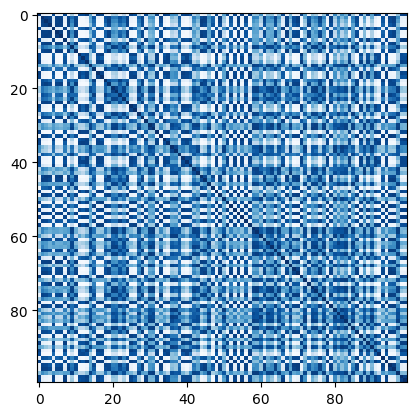

In [30]:
plt.imshow(similarity_adjoint_noisy, interpolation="nearest", origin="upper", cmap="Blues")

Clustering score: 1.0


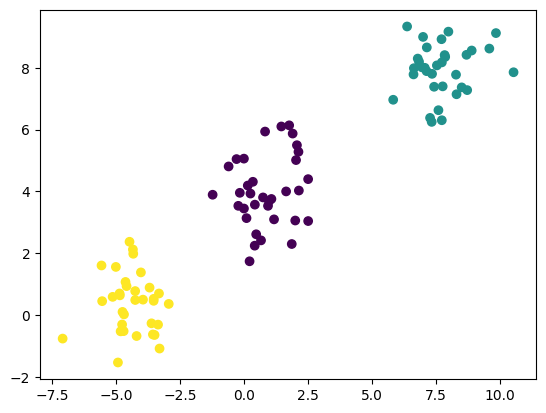

In [31]:
adhoc_spectral = SpectralClustering(3, affinity="precomputed")
cluster_labels = adhoc_spectral.fit_predict(similarity_adjoint_noisy)

# Compute the NMI metric that gives the quality of the results (comparaison to official labeling)
cluster_score = normalized_mutual_info_score(cluster_labels, labels)

# Print the NMI result
print(f"Clustering score: {cluster_score}")

# Display the dataset with computed labeling
plt.scatter(X[:,0], X[:,1], c=cluster_labels)

### 8 - Clustering of ```Iris``` dataset

We propose now to work on the ```Iris``` dataset composed of 150 vectors of 4 features divided into 3 clusters:
https://scikit-learn.org/1.4/auto_examples/datasets/plot_iris_dataset.html

#### 8.1 - Preprocessing

Text(0.5, 0, '3rd Eigenvector')

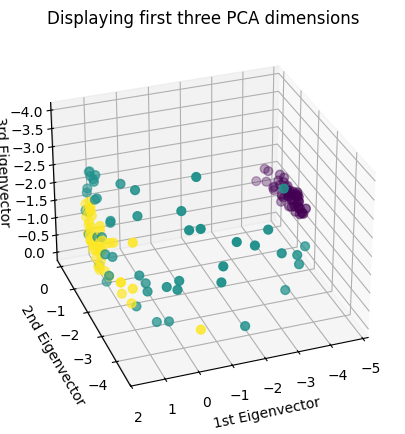

In [32]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
iris = load_iris()

# This is classical machine learning? IRIS is a classical dataset
# 1. make preprocessing adapted for data clustering
X_reduced_iris = PCA(n_components=4).fit_transform(iris.data)
X_reduced_iris = preprocessing.normalize(X_reduced_iris) * np.pi - np.pi/2
# 2. plot the preprocessed data
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)
ax.scatter(
    X_reduced_iris[:, 0],
    X_reduced_iris[:, 1],
    X_reduced_iris[:, 2],
    c=iris.target,
    s=40,
)

ax.set_title("Displaying first three PCA dimensions")
ax.set_xlabel("1st Eigenvector")
ax.set_ylabel("2nd Eigenvector")
ax.set_zlabel("3rd Eigenvector")

#### 8.2 - Perform clustering

In [33]:
# on reprend le sim basique apres le noisy
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

nb_shots = 1024 #1024 by default
sim = AerSimulator(shots=nb_shots)

import numpy as np
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

# The pass manager performs transpilation, optimized for a target machine if specified
pm = generate_preset_pass_manager(backend=sim, optimization_level=1) 

sim_noisy = AerSimulator.from_backend(device_backend)
#I think reading the paper is necessary to implement clustering correctly, for the moment I'll just try to compute the similarity matrix
pm = generate_preset_pass_manager(backend=sim_noisy, optimization_level=1)
similarity_adjoint_noisy = similarity_adjoint_optimized(4, 4, X_reduced_iris, sim_noisy, pm)
#or similarity_swap_noisy = similarity_swap(2, 1, X_NORMALIZED, sim_noisy, pm)
#plt.imshow(similarity_adjoint_noisy, interpolation="nearest", origin="upper", cmap="Blues")
#EN CAS DE NOISE, SWAP est plus robuste (cf p. 35 du papier)

Lancement de la simulation pour 11175 circuits...


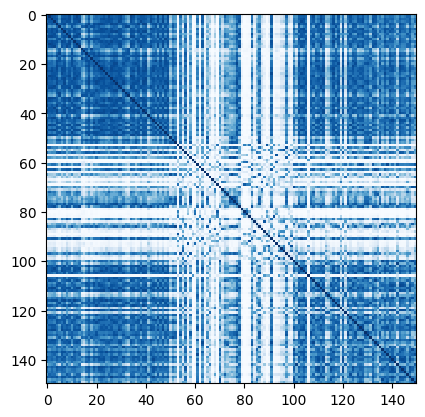

In [34]:
plt.imshow(similarity_adjoint_noisy, interpolation="nearest", origin="upper", cmap="Blues")

### 9 - Improvment of the embedding

#### 9.1 - Change the embedding: Expermient different feature maps

We can see that we have a bad clustering with the Iris dataset. Change the ```embbeding_circuit``` with more complexe ***feature maps*** to try to improve the clustering.

In [35]:
# TODO
def embbeding_circuit_x(nb_qubit, nb_feature, name="input"):
    """
        nb_qubit : number of qubits in the circuit
        nb_feature : number of features of a data vector
        name : name will be the identifier of the ParameterVector
        This function return the circuit of embedding, same than original but with rx instead of rz
        Same than the example from paper
    """
    x = ParameterVector(name, nb_feature)
    qc = QuantumCircuit(nb_qubit)
    
    # TODO
    for i in range(nb_qubit):
        qc.h(i)
        qc.rx(x[i%nb_feature], i)
    return qc

def zfm(nb_feature, nb_rep = 3, name="input"):
    """
        nb_qubit : number of qubits in the circuit
        nb_feature : number of features of a data vector
        name : name will be the identifier of the ParameterVector
        This function return the circuit of embedding, same than original but with rx instead of rz
        Same than the example from paper
    """
    nb_qubit = nb_feature
    x = ParameterVector(name, nb_feature)
    qc = QuantumCircuit(nb_qubit)
    
    # TODO
    for n in range(nb_rep):
        for i in range(nb_qubit):
            qc.h(i)
            qc.rx(x[i%nb_feature], i)
    return qc

def zzfm(nb_feature, nb_rep = 3, name="input"):
    """
        nb_feature : number of features of a data vector. n_qbit = n_feature
        name : name will be the identifier of the ParameterVector
        This function return the circuit of embedding, same than original but with rx instead of rz
        Same than the example from paper
    """
    nb_qubit = nb_feature
    x = ParameterVector(name, nb_feature)
    qc = QuantumCircuit(nb_qubit)
    
    # TODO
    for n in range(nb_rep):
        for i in range(nb_qubit):
            qc.h(i)
            qc.rx(x[i%nb_feature], i)
        for i in range(nb_qubit-1):
            thetaij = (np.pi - x[i%nb_feature]) * (np.pi - x[i+1%nb_feature])
            qc.cx(i, i+1)
            qc.rz(thetaij, i+1)
            qc.cx(i, i+1)
    return qc



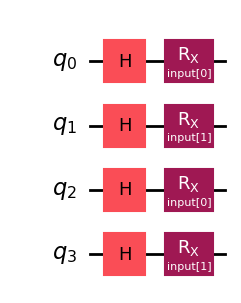

In [36]:
embbeding_circuit_x(4,2).draw('mpl')

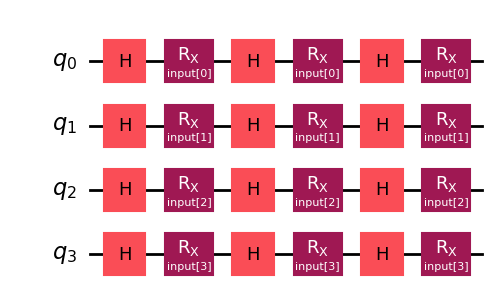

In [37]:
zfm(4, 3).draw('mpl')

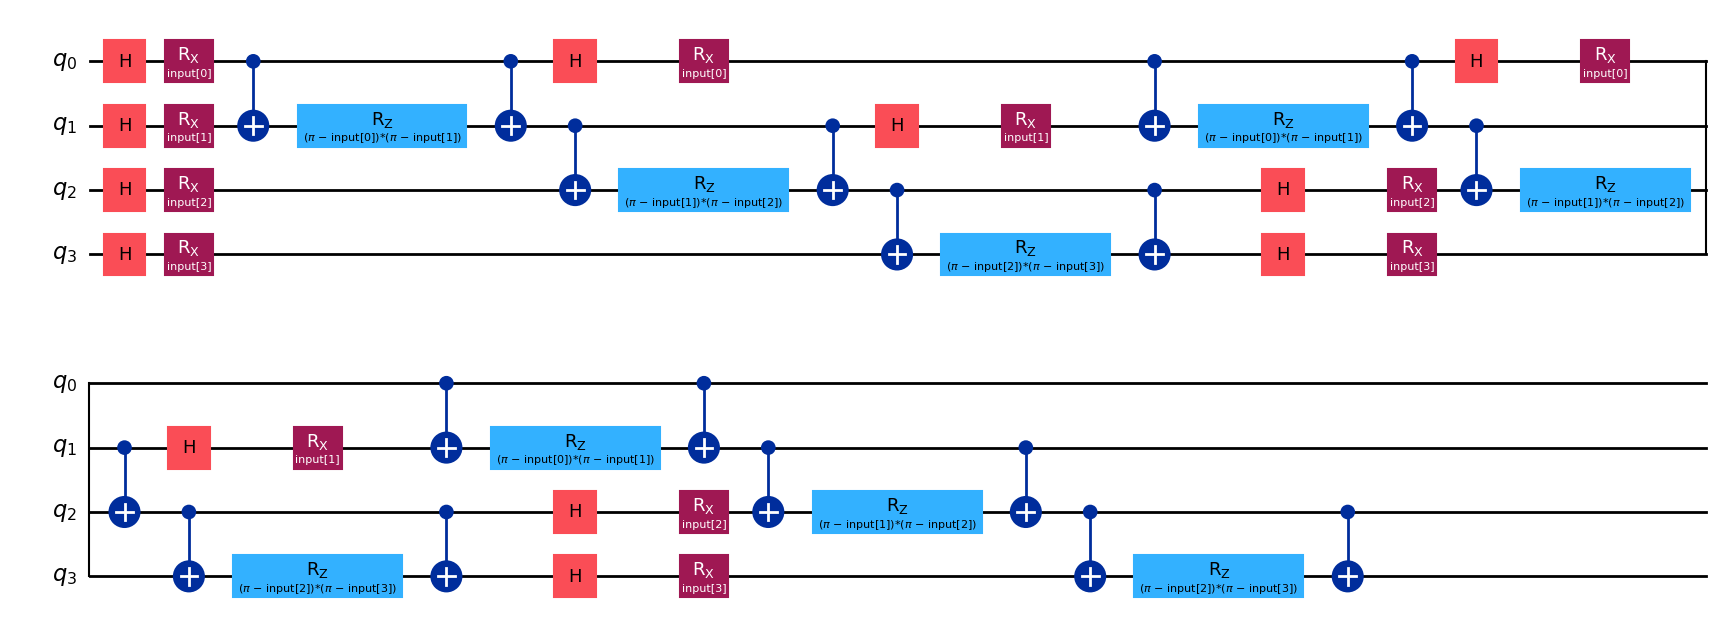

In [38]:
zzfm(4, 3).draw('mpl')

#### 9.2 - Which feature map gave you the best results ?

In [39]:
# Generalisation du similarity adjoint pour prendre en compte les differenrts embeddings
def similarity_adjoint_custom( dataset, backend, pass_manager, adjoint_circuit_func, args: dict):
    n = len(dataset)
    res = np.zeros((n,n)) # similarity matrix to be completed
    qc_base = adjoint_circuit_func(**args)
    qc_base = pass_manager.run(qc_base)

    # Cas ZFM, ou ZZFM
    if 'nb_qubit' not in args:
        args['nb_qubit'] = nb_feature
    
    nb_qubit = args['nb_qubit']
    nb_feature = args['nb_feature']
    
    # String of all zeros to check (e.g., "00" for 2 qubits)
    all_zeros = "0" * nb_qubit
    nb_shots = backend._options.get("shots")
    
    # Fill the diagonal with 1 (similarity with itself)
    for i in range(n):
        res[i][i] = 1.0
    
    # Compute similarities for all pairs
    for i in range(n):
        for j in range(i+1, n):
            dict_i = {}
            for k in range(nb_feature):
                dict_i[f"input1[{k}]"] = dataset[i][k]
                dict_i[f"input2[{k}]"] = dataset[j][k]
            
            qc = qc_base.assign_parameters(dict_i)
            job = backend.run(qc)
            result = job.result()
            counts = result.get_counts()
            
            # Fidelity = probability of measuring all qubits at 0
            fidelity = counts.get(all_zeros, 0) / nb_shots
            
            # Fill the matrix (symmetric)
            res[i][j] = fidelity
            res[j][i] = fidelity
    
    return res

In [ ]:
def similarity_adjoint_optimized2(nb_qubit, nb_feature, dataset, backend, pass_manager, embbeding_circuit):
    n = len(dataset)
    res = np.zeros((n, n))

    qc1 = embbeding_circuit(nb_qubit, nb_feature, "input1")
    qc2 = embbeding_circuit(nb_qubit, nb_feature, "input2")

    qc1.compose(qc2.inverse(), inplace=True)
    qc1.measure_all()

    qc_base = qc1
    qc_base = pass_manager.run(qc_base) 
    
    all_zeros = "0" * nb_qubit
    nb_shots = backend._options.get("shots")

    list_of_circuits = []
    pairs_indices = [] 
    for i in range(n):
        res[i][i] = 0 
        for j in range(i + 1, n):
            dict_params = {}
            for k in range(nb_feature):
                dict_params[f"input1[{k}]"] = dataset[i][k]
                dict_params[f"input2[{k}]"] = dataset[j][k]

            qc = qc_base.assign_parameters(dict_params)
            list_of_circuits.append(qc)
            pairs_indices.append((i, j))

    print(f"Lancement de la simulation pour {len(list_of_circuits)} circuits...")
    job = backend.run(list_of_circuits) 
    result = job.result()
    all_counts = result.get_counts()

    for idx, (i, j) in enumerate(pairs_indices):
        counts = all_counts[idx]
        fidelity = counts.get(all_zeros, 0) / nb_shots
        res[i][j] = fidelity
        res[j][i] = fidelity
        
    return res


In [63]:
sim_noisy = AerSimulator.from_backend(device_backend)
pm = generate_preset_pass_manager(backend=sim_noisy, optimization_level=1) 
args_x = {'nb_qubit': 2, 'nb_feature': 2}
# matrix_x = similarity_adjoint_optimized_universal(args_x, , , pm, embbeding_circuit_x)
matrix_x = similarity_adjoint_optimized2(2, 2, X_NORMALIZED, sim, pm, embbeding_circuit_x)

Lancement de la simulation pour 4950 circuits...


In [44]:
# Comparaison
nb_features = X_reduced_iris.shape[1]
nb_qubits = 5
nb_rep = 3

adjoint_matrix_circuit_x = similarity_adjoint_universal(X_reduced_iris, sim, pm, embbeding_circuit_x, args={'nb_qubit': nb_qubits, 'nb_feature': nb_features})
adjoint_matrix_zfm = similarity_adjoint_universal(2, 2, X_reduced_iris, sim, pm, zfm, args={'nb_qubit': nb_qubits, 'nb_feature': nb_features, 'nb_rep': nb_rep})
adjoint_matrix_zzfm = similarity_adjoint_universal(2, 2, X_reduced_iris, sim, pm, zzfm, args={'nb_qubit': nb_qubits, 'nb_feature': nb_features, 'nb_rep': nb_rep})


KeyError: "no parameter named 'input1[0]' is present"

In [ ]:
plt.imshow(adjoint_matrix_circuit_x, interpolation="nearest", origin="upper", cmap="Blues")
plt.title("Embbeding circuit x")
plt.show()

In [ ]:
plt.imshow(adjoint_matrix_zfm, interpolation="nearest", origin="upper", cmap="Blues")
plt.title("ZFM")
plt.show()

In [ ]:
plt.imshow(adjoint_matrix_zzfm, interpolation="nearest", origin="upper", cmap="Blues")
plt.title("ZZFM")
plt.show()


NameError: name 'adjoint_matrix_zzfm' is not defined

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

# Matrices à comparer
matrices = {
    "x": adjoint_matrix_circuit_x,
    "zfm": adjoint_matrix_zfm,
    "zzfm": adjoint_matrix_zzfm
}

results = {}

print("\n Quantum Kernel Clustering Comparison\n")

for name, sim_matrix in matrices.items():
    cluster = SpectralClustering(3, affinity="precomputed", random_state=42)
    labels_pred = cluster.fit_predict(sim_matrix)
    nmi = normalized_mutual_info_score(labels_pred, labels)
    results[name] = nmi
    print(f"  {name.upper():<6} → NMI: {nmi:.6f}")

# Meilleur résultat
best_name = max(results, key=results.get)
best_score = results[best_name]

print(f"\nBest: {best_name.upper()} with NMI = {best_score:.6f}\n")